In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.models import load_model

In [4]:
# map file directories to a variable

train_data_dir= "/kaggle/input/brain-tumor-mri-dataset/Training"
test_data_dir = "/kaggle/input/brain-tumor-mri-dataset/Testing"

In [5]:
IMAGE_SIZE =(256,256)
BATCH_SIZE = 16

# Training and validation datasets
X_train, X_val = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,  # Use 20% of the data for validation
    subset='both',  # Specify the subset
    seed=42,  # Ensure reproducibility
    image_size=IMAGE_SIZE,  # Resize images to 128x128
    batch_size=BATCH_SIZE  # Batch size
)

# Test dataset
X_test = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    shuffle =False,
    seed=42,  # Ensure reproducibility
    image_size=IMAGE_SIZE,  # Resize images to 128x128
    batch_size=16  # Batch size
)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


In [6]:
# description: this function resizes an image
# arguments: image (the image to normalize), labels (the label of the image to normalize)
# steps: divide the image size by the standard 255 and force result into a float 32 format

def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

In [7]:
# description: this function performs further normalization tailored for MRI-scans
# arguments: image (the image to normalize), labels (the label of the image to normalize)
# steps: applies mean and standard deviation calculations to the image,
#        and then normalizes using Z-score

def mri_normalize(image, label):
    """Applies MRI-specific normalization."""
    # Z-score normalization
    mean = tf.reduce_mean(image)
    std = tf.math.reduce_std(image)
    normalized_image = (image - mean) / std
    return normalized_image, label

In [8]:
# apply normalization and transform images into float32
X_train_normalized = X_train.map(normalize_img)
X_val_normalized = X_val.map(normalize_img)
X_test_normalized = X_test.map(normalize_img)

# apply further normalization for MRI scans
X_train_normalized = X_train_normalized.map(mri_normalize)
X_val_normalized = X_val_normalized.map(mri_normalize)
X_test_normalized = X_test.map(mri_normalize)

In [9]:
# check shape of normalized data
for image_batch, label_batch in X_train_normalized.take(1):
    print(f"train image batch shape: {image_batch.shape}")
    print(f"rain label batch shape: {label_batch.shape}")

for image_batch, label_batch in X_val_normalized.take(1):
    print(f"val image batch shape: {image_batch.shape}")
    print(f"val label batch shape: {label_batch.shape}")

for image_batch, label_batch in X_test_normalized.take(1):
    print(f"val image batch shape: {image_batch.shape}")
    print(f"val label batch shape: {label_batch.shape}")

train image batch shape: (16, 256, 256, 3)
rain label batch shape: (16,)
val image batch shape: (16, 256, 256, 3)
val label batch shape: (16,)
val image batch shape: (16, 256, 256, 3)
val label batch shape: (16,)


In [10]:
# description: this function plots the MRI scans
# arguments: dataset (the dataset source), class_names (the labels for the images),
#            num_images (the amount of images to be shown), figsize (the desired size of the images)
# steps:

def plot_images_with_labels(dataset, class_names, num_images=25, figsize=(15, 15)):
    plt.figure(figsize=figsize)
    for images, labels in dataset.take(1):
        for i in range(min(num_images, len(images))):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("float32"), cmap='gray')
            plt.title(class_names[labels[i]])
            plt.axis("off")
    plt.tight_layout()
    plt.show()

Original Data:


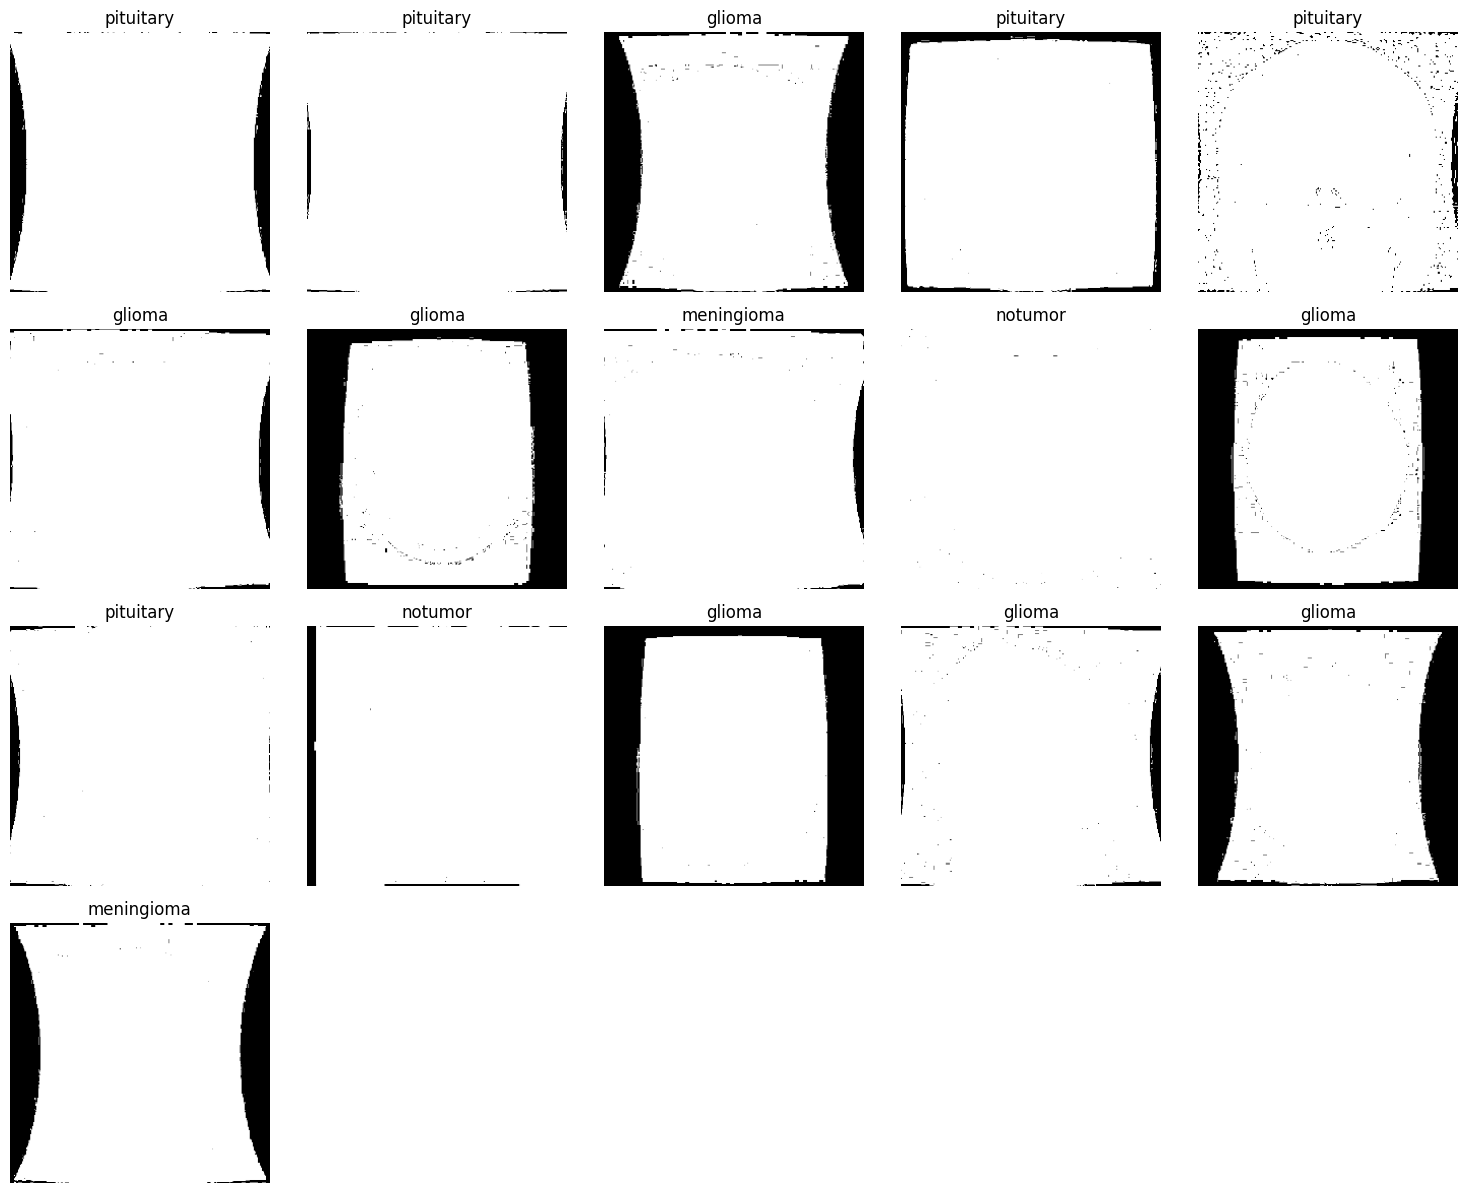

Normalized Data:


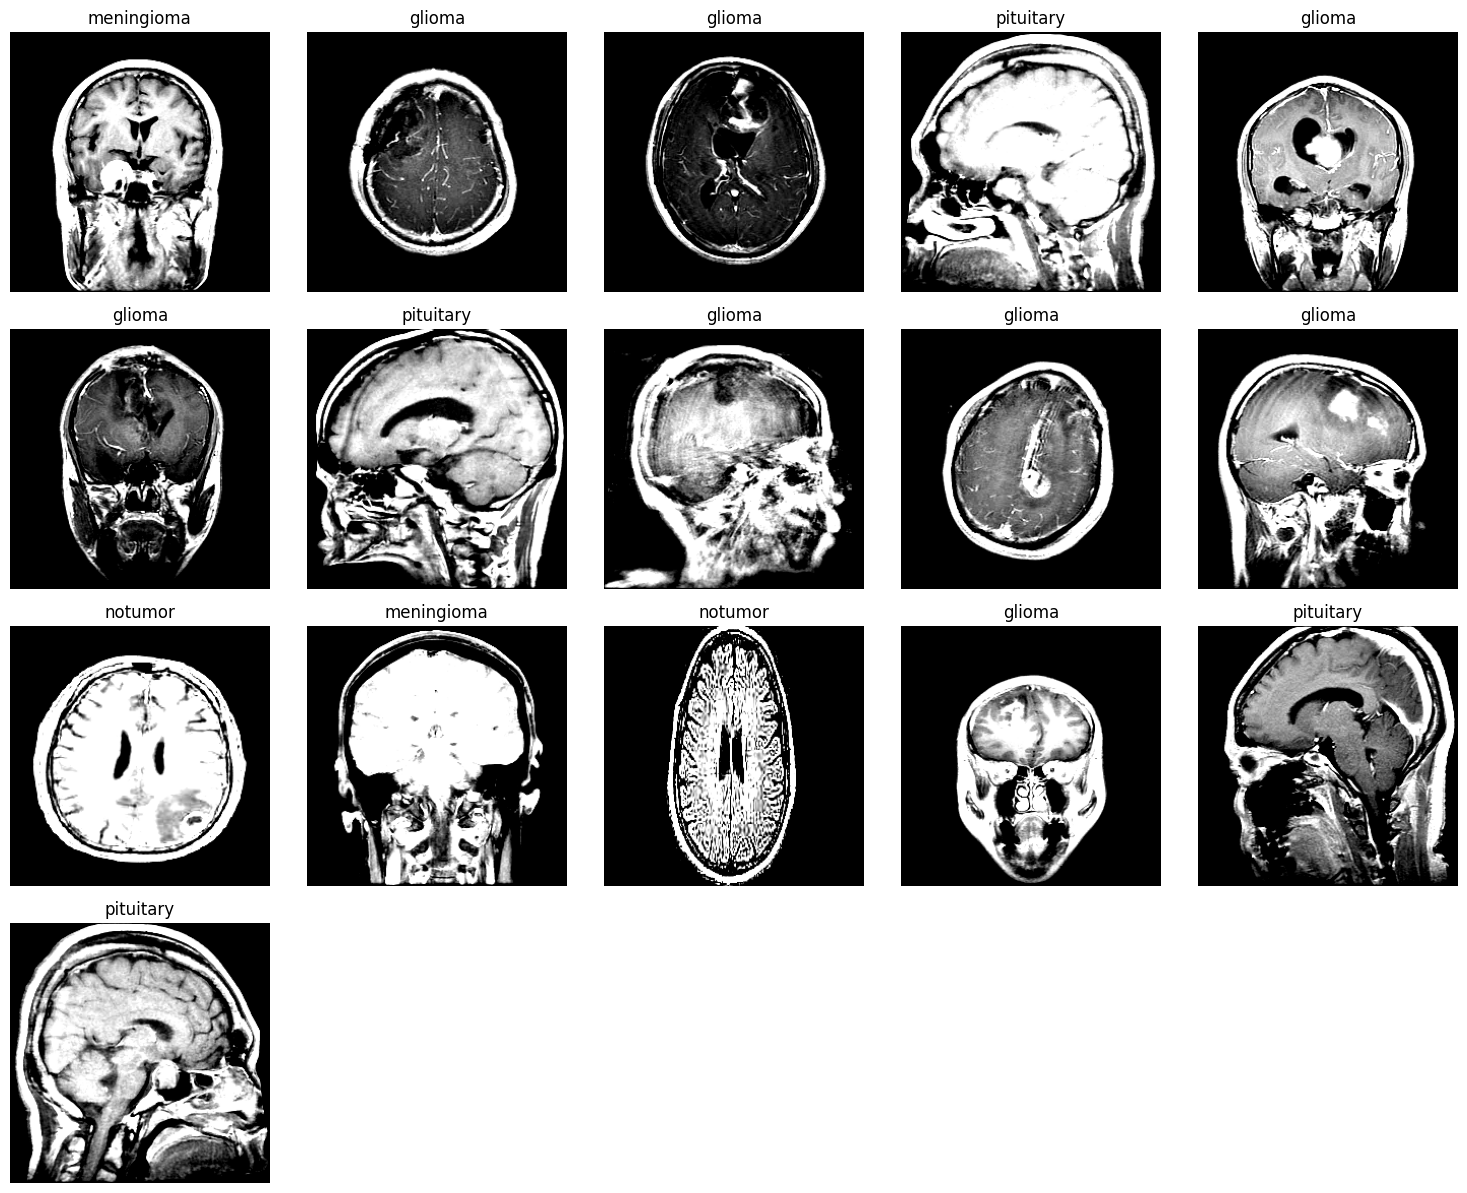

In [11]:
# Get class names from the dataset
class_names = X_train.class_names

# Plot original data with labels
print("Original Data:")
plot_images_with_labels(X_train, class_names)

# Plot normalized data with labels
print("Normalized Data:")
plot_images_with_labels(X_train_normalized, class_names)

In [12]:
# define a function to one hot encode the classes
def one_hot_encode(image, labels):
    # Assuming 'num_classes' is defined
    return image, tf.one_hot(labels, depth=len(class_names))

In [13]:
# one hot encode the dataset using .map method as we are dealing with a mapped dataset

X_train_encoded = X_train_normalized.map(one_hot_encode)
X_val_encoded = X_val_normalized.map(one_hot_encode)
X_test_encoded = X_test_normalized.map(one_hot_encode)

In [14]:
# check shape of one-hot-encoded data
for image_batch, label_batch in X_train_encoded.take(1):
    print(f"train image batch shape: {image_batch.shape}")
    print(f"rain label batch shape: {label_batch.shape}")

for image_batch, label_batch in X_val_encoded.take(1):
    print(f"val image batch shape: {image_batch.shape}")
    print(f"val label batch shape: {label_batch.shape}")

for image_batch, label_batch in X_val_encoded.take(1):
    print(f"val image batch shape: {image_batch.shape}")
    print(f"val label batch shape: {label_batch.shape}")

train image batch shape: (16, 256, 256, 3)
rain label batch shape: (16, 4)
val image batch shape: (16, 256, 256, 3)
val label batch shape: (16, 4)
val image batch shape: (16, 256, 256, 3)
val label batch shape: (16, 4)


In [15]:
# further preprocessing before model training and fitting

X_train_encoded = X_train_encoded.shuffle(buffer_size=500) # ensures randomness
#                                                                              by randomizing order of samples to avoid any
#                                                                              information present in the sequencing
#                                                                              of the images from being learnt by the model

X_test_encoded = X_test_encoded.shuffle(buffer_size=500)

In [16]:
# check shape of the fully pre-processed data
for image_batch, label_batch in X_train_encoded.take(1):
    print(f"train image batch shape: {image_batch.shape}")
    print(f"rain label batch shape: {label_batch.shape}")

for image_batch, label_batch in X_val_encoded.take(1):
    print(f"val image batch shape: {image_batch.shape}")
    print(f"val label batch shape: {label_batch.shape}")

train image batch shape: (16, 256, 256, 3)
rain label batch shape: (16, 4)
val image batch shape: (16, 256, 256, 3)
val label batch shape: (16, 4)


In [17]:
# description: define the baseline model
# arguments: imput shape (the shape of the images in the dataset), num_classes (the number of possible classes) and regularizer
# steps: sequence of convolution layers paired with max pooling layers, followed by flattening and output layers

def initialize_baseline_model (imput_shape, num_classes, regularizer):

    model = models.Sequential()

    ### first Convolution & MaxPooling
    model.add(layers.Conv2D(5, (4,4), padding='same', activation="relu", input_shape=imput_shape))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### second Convolution & MaxPooling
    model.add(layers.Conv2D(10, (3,3), padding='same', activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### third Convolution & MaxPooling
    model.add(layers.Conv2D(20, (3,3), padding='same', activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### fourth Convolution & MaxPooling
    model.add(layers.Conv2D(40, (3,3), padding='same', activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### fith Convolution & MaxPooling
    model.add(layers.Conv2D(80, (3,3), padding='same', activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### sitxh Convolution & MaxPooling
    model.add(layers.Conv2D(160, (3,3), padding='same', activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### seveth Convolution & MaxPooling
    model.add(layers.Conv2D(360, (2,2), padding='same', activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### eight Convolution & MaxPooling
    model.add(layers.Conv2D(720, (2,2), padding='same', activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### Flattening
    model.add(layers.Flatten())

    ### Last layer - one dense layer and classification layer with output corresponding to num_classes
    model.add(layers.Dense(num_classes+30, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    ### Model compilation
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

    return model

In [18]:
# define early stopping criteria for the model
es = EarlyStopping(
    patience =10,
    restore_best_weights = True)

# define inputs for the model
input_shape = (256, 256, 3)
num_classes = len(class_names)

In [98]:
# initialize the model
baseline_model = initialize_baseline_model (input_shape, num_classes, reg_l1)

# fit the model
# no need for batch size as pre-processing already does that
# no need for a val split as pre-processing already does that
history_base = baseline_model.fit(
    X_train_encoded,
    validation_data = X_val_encoded,
    batch_size = BATCH_SIZE,
    epochs = 5000,
    callbacks = [es],
    verbose = 1
)

Epoch 1/5000
286/286 ━━━━━━━━━━━━━━━━━━━━ 48s 59ms/step - accuracy: 0.4731 - loss: 1.0840 - val_accuracy: 0.7697 - val_loss: 0.6012
Epoch 2/5000
286/286 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.7945 - loss: 0.5109 - val_accuracy: 0.8056 - val_loss: 0.4808
Epoch 3/5000
286/286 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8352 - loss: 0.4071 - val_accuracy: 0.8520 - val_loss: 0.4077
Epoch 4/5000
286/286 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8946 - loss: 0.3002 - val_accuracy: 0.8967 - val_loss: 0.3014
Epoch 5/5000
286/286 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9264 - loss: 0.1999 - val_accuracy: 0.8809 - val_loss: 0.3380
Epoch 6/5000
286/286 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9366 - loss: 0.1721 - val_accuracy: 0.8993 - val_loss: 0.3235
Epoch 7/5000
286/286 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9645 - loss: 0.1163 - val_accuracy: 0.9194 - val_loss: 0.2636
Epoch 8/5000
286/286 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9742 - loss: 

In [99]:
baseline_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_72 (Conv2D)              │ (None, 256, 256, 5)    │           245 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 128, 128, 5)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 128, 128, 10)   │           460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 64, 64, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 64, 64, 20)     │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (None, 32, 32, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 32, 32, 40)     │         7,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_75 (MaxPooling2D) │ (None, 16, 16, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 16, 16, 80)     │        28,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_76 (MaxPooling2D) │ (None, 8, 8, 80)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 8, 8, 160)      │       115,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_77 (MaxPooling2D) │ (None, 4, 4, 160)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 4, 4, 360)      │       230,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_78 (MaxPooling2D) │ (None, 2, 2, 360)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 2, 2, 720)      │     1,037,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_79 (MaxPooling2D) │ (None, 1, 1, 720)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 720)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 34)             │        24,514 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │           140 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,340,819 (16.56 MB)

 Trainable params: 1,446,939 (5.52 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,893,880 (11.04 MB)

In [100]:
baseline_model.evaluate(X_test_encoded)

82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9203 - loss: 0.2992


[0.25087618827819824, 0.9267734289169312]

In [19]:
# description: a function to plot evaluation metrics for train and test set
# arguments: the output of the model
# steps: if no image, create one. plot loss function and accuracy

def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

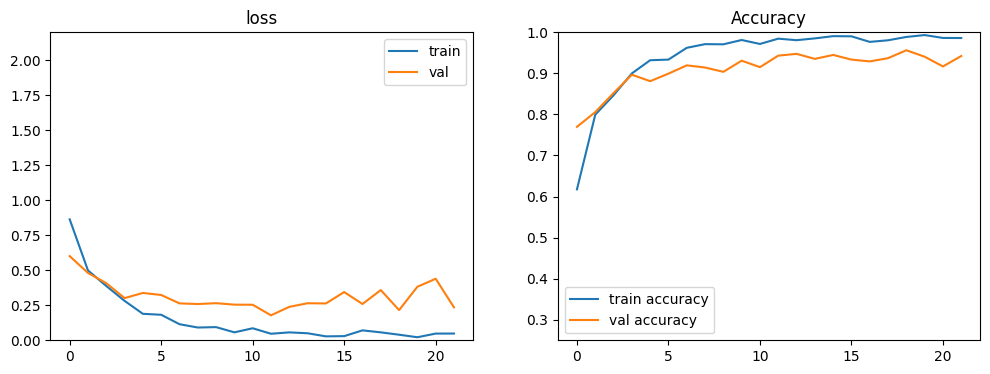

In [102]:
plot_history(history_base, title='baseline_model', axs=None, exp_name="")

In [ ]:
# description: define the baseline model
# arguments: imput shape (the shape of the images in the dataset), num_classes (the number of possible classes) and regularizer
# steps:

def initialize_model_2 (imput_shape, num_classes, regularizer):

    model = models.Sequential()

    ### first Convolution & MaxPooling
    model.add(layers.Conv2D(5, (4,4), padding='same', activation="relu", input_shape=imput_shape))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### second Convolution & MaxPooling
    model.add(layers.Conv2D(10, (3,3), padding='same', activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### third Convolution & MaxPooling
    model.add(layers.Conv2D(20, (3,3), padding='same', activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### fourth Convolution & MaxPooling
    model.add(layers.Conv2D(40, (3,3), padding='same', activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### fith Convolution & MaxPooling
    model.add(layers.Conv2D(80, (3,3), padding='same', activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### sitxh Convolution & MaxPooling
    model.add(layers.Conv2D(160, (3,3), padding='same', activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### seveth Convolution & MaxPooling
    model.add(layers.Conv2D(360, (2,2), padding='same', activation="relu", kernel_regularizer = reg_l1))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### eight Convolution & MaxPooling
    model.add(layers.Conv2D(720, (2,2), padding='same', activation="relu", kernel_regularizer = reg_l1))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### Flattening
    model.add(layers.Flatten())

    ### Last layer - one dense layer and classification layer with output corresponding to num_classes
    model.add(layers.Dense(num_classes+40, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    ### Model compilation
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

    return model

In [20]:
reg_l1 = regularizers.L1(0.001)

In [22]:
# initialize the model
model_2 = initialize_model_2 (input_shape, num_classes, reg_l1)

# fit the model
# no need for batch size as pre-processing already does that
# no need for a val split as pre-processing already does that
history_2 = model_2.fit(
    X_train_encoded,
    validation_data = X_val_encoded,
    batch_size = BATCH_SIZE,
    epochs = 5000,
    callbacks = [es],
    verbose = 1
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5000


I0000 00:00:1733930283.950071     101 service.cc:145] XLA service 0x7b3bc8010f30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733930283.950125     101 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733930283.950129     101 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/286 ━━━━━━━━━━━━━━━━━━━━ 2:44:39 35s/step - accuracy: 0.3125 - loss: 26.9074

I0000 00:00:1733930311.517589     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


286/286 ━━━━━━━━━━━━━━━━━━━━ 54s 69ms/step - accuracy: 0.3309 - loss: 6.5547 - val_accuracy: 0.5000 - val_loss: 1.2228
Epoch 2/5000
286/286 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.5062 - loss: 1.1815 - val_accuracy: 0.5447 - val_loss: 1.1311
Epoch 3/5000
286/286 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.5468 - loss: 1.0968 - val_accuracy: 0.6550 - val_loss: 1.0126
Epoch 4/5000
286/286 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.6457 - loss: 1.0094 - val_accuracy: 0.7662 - val_loss: 0.9329
Epoch 5/5000
286/286 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.7795 - loss: 0.7986 - val_accuracy: 0.8546 - val_loss: 0.7098
Epoch 6/5000
286/286 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8499 - loss: 0.6163 - val_accuracy: 0.8616 - val_loss: 0.6224
Epoch 7/5000
286/286 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8900 - loss: 0.5114 - val_accuracy: 0.8608 - val_loss: 0.5959
Epoch 8/5000
286/286 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.9163 - loss: 0.4459 - val_

In [23]:
model_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 5)    │           245 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 5)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 10)   │           460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 20)     │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 40)     │         7,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 80)     │        28,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 80)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 160)      │       115,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 160)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 360)      │       230,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 2, 2, 360)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 2, 2, 720)      │     1,037,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 1, 1, 720)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 720)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 44)             │        31,724 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           180 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,362,569 (16.64 MB)

 Trainable params: 1,454,189 (5.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,908,380 (11.09 MB)

In [24]:
model_2.evaluate(X_test_encoded)

82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8350 - loss: 0.6991


[0.7715924382209778, 0.8253241777420044]

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

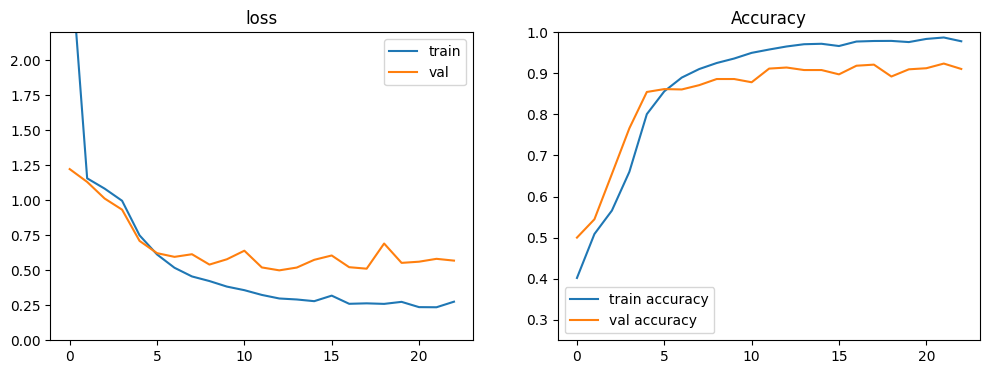

In [25]:
plot_history(history_2, title='model_2', axs=None, exp_name="")

In [ ]:
# description: define the baseline model
# arguments: imput shape (the shape of the images in the dataset), num_classes (the number of possible classes) and regularizer
# steps:

def initialize_model_3 (imput_shape, num_classes, regularizer):

    model = models.Sequential()

    ### first Convolution & MaxPooling
    model.add(layers.Conv2D(50, (4,4), padding='same', activation="relu", input_shape=imput_shape))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### second Convolution & MaxPooling
    model.add(layers.Conv2D(100, (3,3), padding='same', activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### third Convolution & MaxPooling
    model.add(layers.Conv2D(200, (3,3), padding='same', activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### fourth Convolution & MaxPooling
    model.add(layers.Conv2D(400, (3,3), padding='same', activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### fith Convolution & MaxPooling
    model.add(layers.Conv2D(800, (3,3), padding='same', activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### Flattening
    model.add(layers.Flatten())

    ### Last layer - one dense layer and classification layer with output corresponding to num_classes
    model.add(layers.Dense(num_classes+40, activation='relu'))
    model.add(layers.Dense(num_classes+20, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    ### Model compilation
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

    return model

In [56]:
# initialize the model
model_3 = initialize_model_3 (input_shape, num_classes, reg_l1)

# fit the model
# no need for batch size as pre-processing already does that
# no need for a val split as pre-processing already does that
history_3 = model_3.fit(
    X_train_encoded,
    validation_data = X_val_encoded,
    batch_size = BATCH_SIZE,
    epochs = 5000,
    callbacks = [es],
    verbose = 1
)

Epoch 1/5000
286/286 ━━━━━━━━━━━━━━━━━━━━ 77s 145ms/step - accuracy: 0.5123 - loss: 1.1678 - val_accuracy: 0.7723 - val_loss: 0.6025
Epoch 2/5000
286/286 ━━━━━━━━━━━━━━━━━━━━ 27s 77ms/step - accuracy: 0.8177 - loss: 0.4847 - val_accuracy: 0.8520 - val_loss: 0.3664
Epoch 3/5000
286/286 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.8689 - loss: 0.3404 - val_accuracy: 0.8520 - val_loss: 0.5057
Epoch 4/5000
286/286 ━━━━━━━━━━━━━━━━━━━━ 27s 78ms/step - accuracy: 0.8913 - loss: 0.2801 - val_accuracy: 0.8967 - val_loss: 0.2940
Epoch 5/5000
286/286 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.9308 - loss: 0.1906 - val_accuracy: 0.8862 - val_loss: 0.3794
Epoch 6/5000
286/286 ━━━━━━━━━━━━━━━━━━━━ 27s 78ms/step - accuracy: 0.9358 - loss: 0.1690 - val_accuracy: 0.9046 - val_loss: 0.3966
Epoch 7/5000
286/286 ━━━━━━━━━━━━━━━━━━━━ 28s 77ms/step - accuracy: 0.9544 - loss: 0.1319 - val_accuracy: 0.9221 - val_loss: 0.2640
Epoch 8/5000
286/286 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.9685 

In [57]:
model_3.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_122 (Conv2D)             │ (None, 256, 256, 50)   │         2,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_113               │ (None, 128, 128, 50)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_123 (Conv2D)             │ (None, 128, 128, 100)  │        45,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_114               │ (None, 64, 64, 100)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_124 (Conv2D)             │ (None, 64, 64, 200)    │       180,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_115               │ (None, 32, 32, 200)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_125 (Conv2D)             │ (None, 32, 32, 400)    │       720,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_116               │ (None, 16, 16, 400)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_126 (Conv2D)             │ (None, 16, 16, 800)    │     2,880,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_117               │ (None, 8, 8, 800)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 44)             │     2,252,844 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 24)             │         1,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 4)              │           100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,248,924 (69.61 MB)

 Trainable params: 6,082,974 (23.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,165,950 (46.41 MB)

In [58]:
model_3.evaluate(X_test_encoded)

82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.8946 - loss: 0.3535


[0.3513023555278778, 0.8947368264198303]